In [2]:
import re
import numpy as np

def parse_and_process_iq(log_lines):
    # 存储结构：{counter: [ {...}, ... ]}
    data_per_counter = {}
    ranging_counter = None
    current_data = []
    for line in log_lines:
        # 检测counter标记
        m = re.search(r'I: Ranging data get completed for ranging counter (\d+)', line)
        if m:
            if ranging_counter is not None and current_data:
                # 按channel排序后保存
                current_data.sort(key=lambda x: x['channel'])
                data_per_counter[ranging_counter] = current_data
            ranging_counter = int(m.group(1))
            current_data = []
        # 解析IQ行
        m = re.match(r'id:(\d+), f:(\d+), ch:(\d+), ap:(\d+), li:(-?\d+), lq:(-?\d+), pi:(-?\d+), pq:(-?\d+)', line)
        if m:
            failed = int(m.group(2))
            if failed:
                continue
            channel = int(m.group(3))
            li, lq, pi, pq = map(int, [m.group(5), m.group(6), m.group(7), m.group(8)])
            # local/peer幅值和相位
            local_amp  = np.hypot(li, lq)
            local_phs  = np.arctan2(lq, li)
            peer_amp   = np.hypot(pi, pq)
            peer_phs   = np.arctan2(pq, pi)
            # signal = local x conj(peer)
            sig_i = li * pi - lq * pq
            sig_q = li * pq + lq * pi
            sig_amp = np.hypot(sig_i, sig_q)
            sig_phs = np.arctan2(sig_q, sig_i)
            entry = {
                'channel': channel,
                'local':  {'i': li, 'q': lq, 'amplitude': local_amp, 'phase': local_phs},
                'peer':   {'i': pi, 'q': pq, 'amplitude': peer_amp, 'phase': peer_phs},
                'signal': {'i': sig_i, 'q': sig_q, 'amplitude': sig_amp, 'phase': sig_phs},
            }
            current_data.append(entry)
    # 最后一组
    if ranging_counter is not None and current_data:
        current_data.sort(key=lambda x: x['channel'])
        data_per_counter[ranging_counter] = current_data
    return data_per_counter

# 用法举例
if __name__ == '__main__':
    # 1mcable.iq, angle.iq.test, close.AT.iq.txt, cable.angle.test
    # poster data in darkroom:dark.room.t2
    with open('dark.room.t2.txt', 'r', encoding='utf-8') as f:
        log_lines = f.readlines()
    data_per_counter = parse_and_process_iq(log_lines)

    # 访问数据示例
    for counter, ch_list in data_per_counter.items():
        print(f'Counter {counter}:')
        for entry in ch_list:
            ch = entry['channel']
            la, lp = entry['local']['amplitude'], entry['local']['phase']
            pa, pp = entry['peer']['amplitude'], entry['peer']['phase']
            sa, sp = entry['signal']['amplitude'], entry['signal']['phase']
            print(f' ch{ch}: local_amp={la:.1f} local_phase={lp:.3f}  '
                  f'peer_amp={pa:.1f} peer_phase={pp:.3f}  '
                  f'signal_amp={sa:.1f} signal_phase={sp:.3f}')

Counter 0:
 ch2: local_amp=143.2 local_phase=-0.909  peer_amp=144.9 peer_phase=1.772  signal_amp=20757.5 signal_phase=0.863
 ch5: local_amp=139.3 local_phase=-2.331  peer_amp=143.5 peer_phase=2.258  signal_amp=20000.7 signal_phase=-0.073
 ch8: local_amp=136.9 local_phase=-0.169  peer_amp=142.1 peer_phase=-0.800  signal_amp=19466.0 signal_phase=-0.969
 ch11: local_amp=138.8 local_phase=-0.939  peer_amp=145.7 peer_phase=-0.815  signal_amp=20228.1 signal_phase=-1.753
 ch14: local_amp=142.8 local_phase=2.495  peer_amp=151.3 peer_phase=1.199  signal_amp=21612.5 signal_phase=-2.589
 ch17: local_amp=145.0 local_phase=-1.945  peer_amp=155.3 peer_phase=-1.700  signal_amp=22522.3 signal_phase=2.638
 ch20: local_amp=143.7 local_phase=-2.534  peer_amp=153.9 peer_phase=-2.014  signal_amp=22110.7 signal_phase=1.735
 ch26: local_amp=137.9 local_phase=0.294  peer_amp=152.5 peer_phase=-0.355  signal_amp=21034.7 signal_phase=-0.061
 ch29: local_amp=137.0 local_phase=0.296  peer_amp=153.7 peer_phase=-1.2

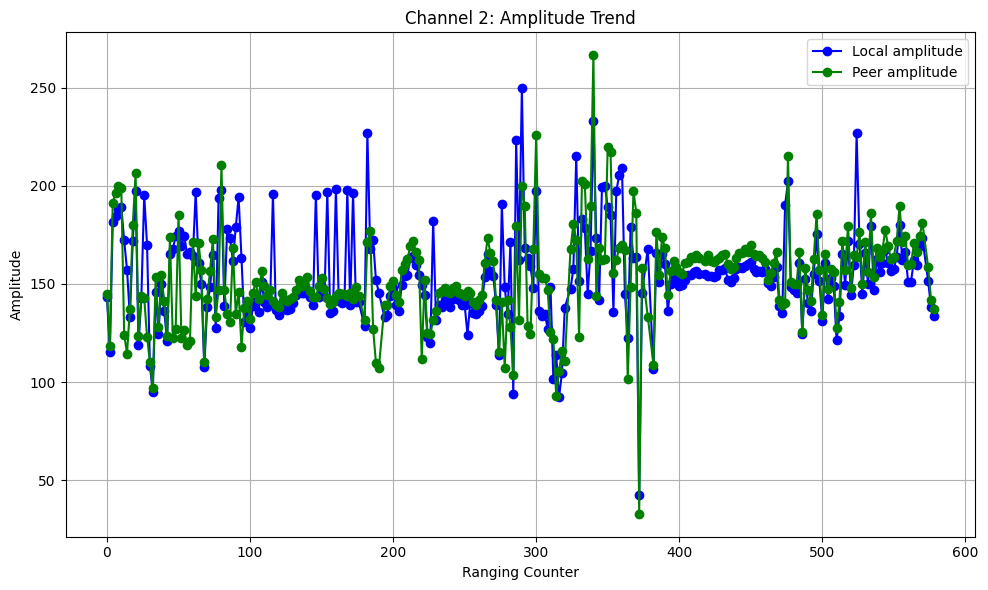

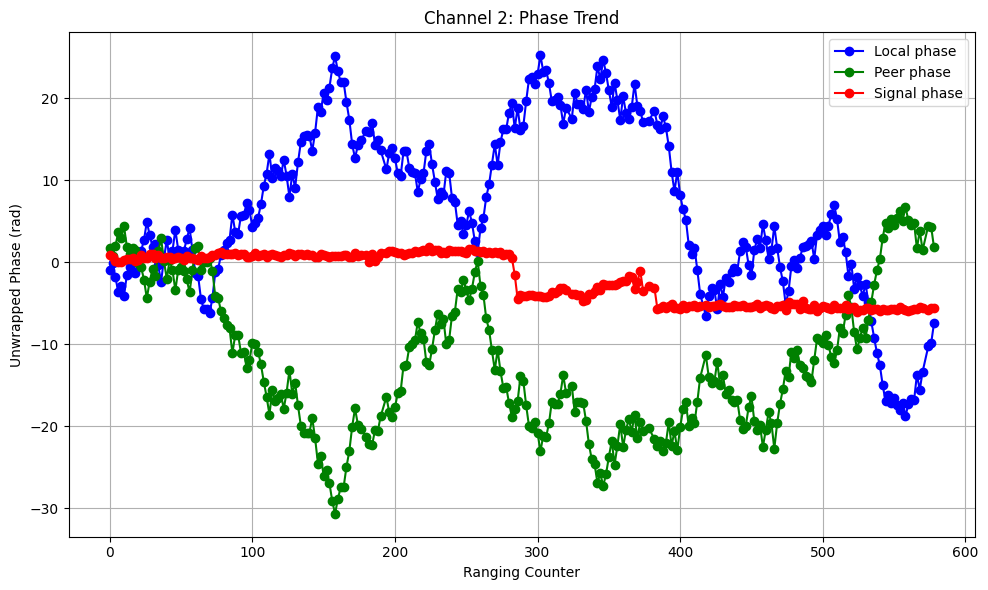

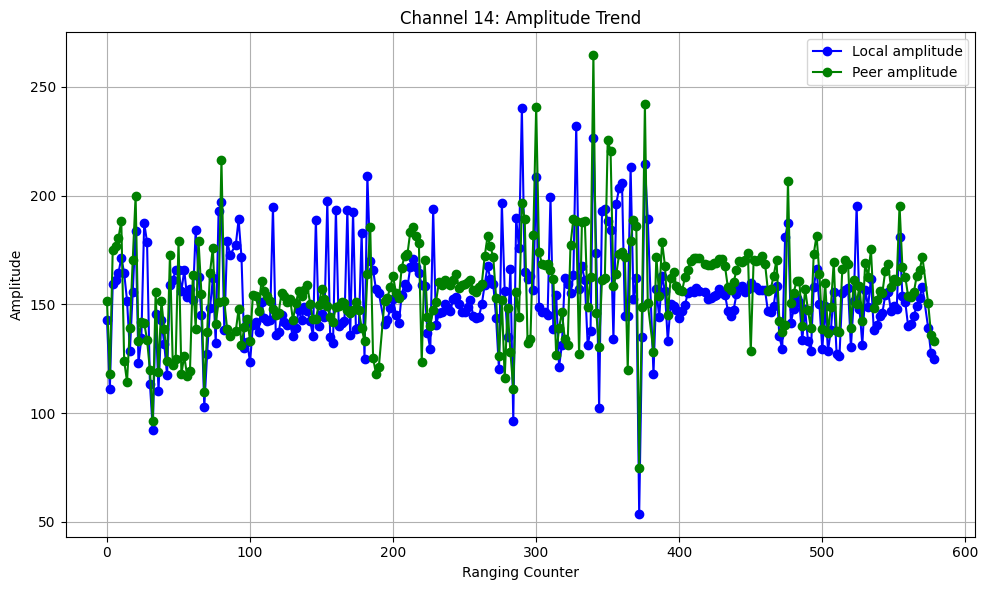

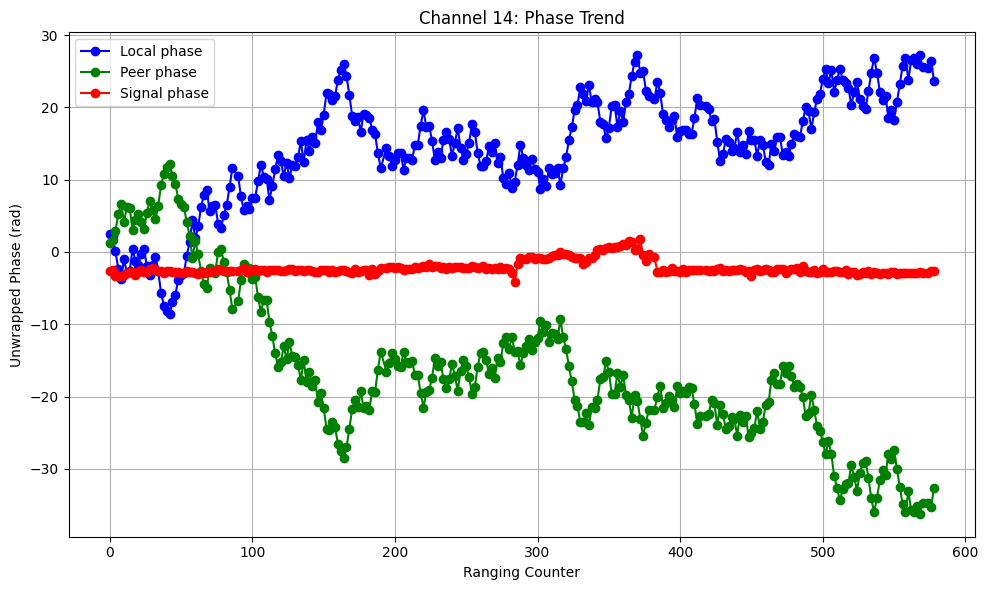

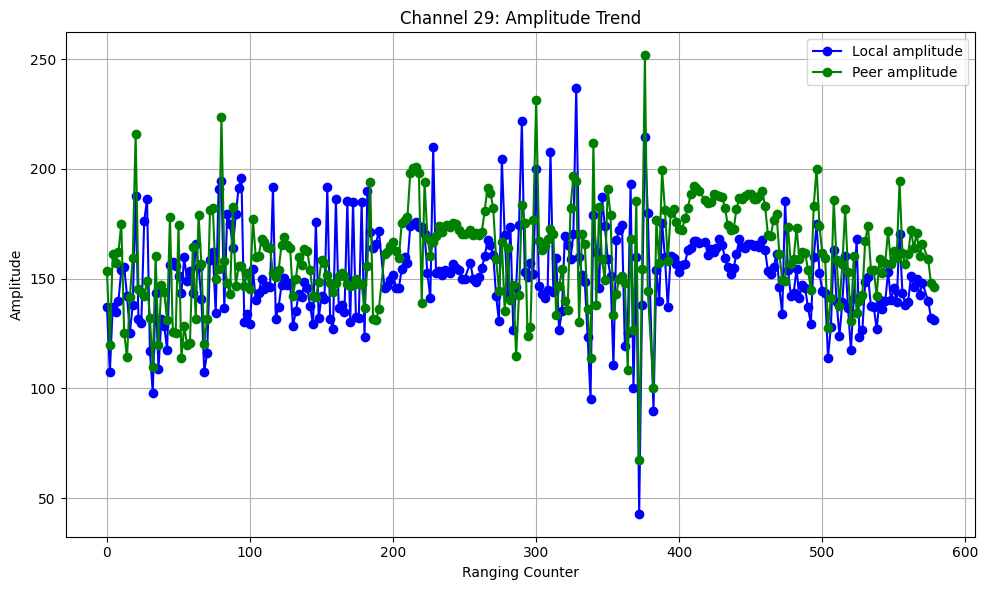

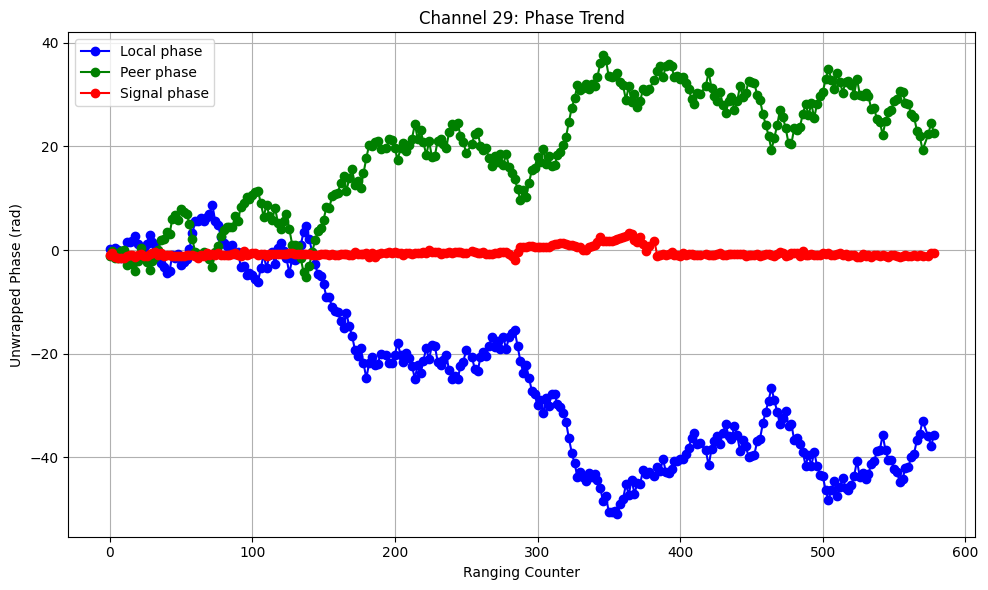

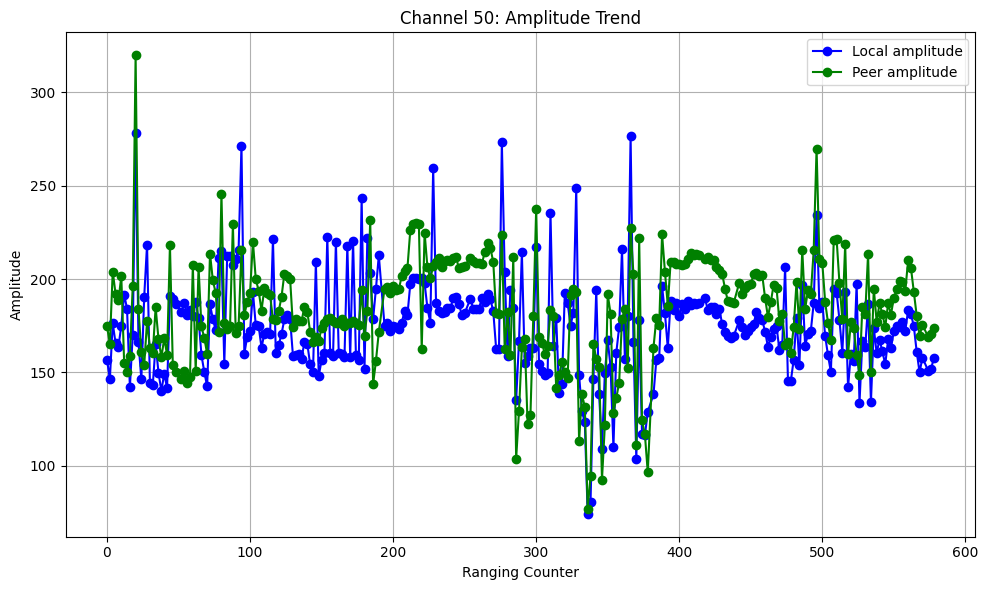

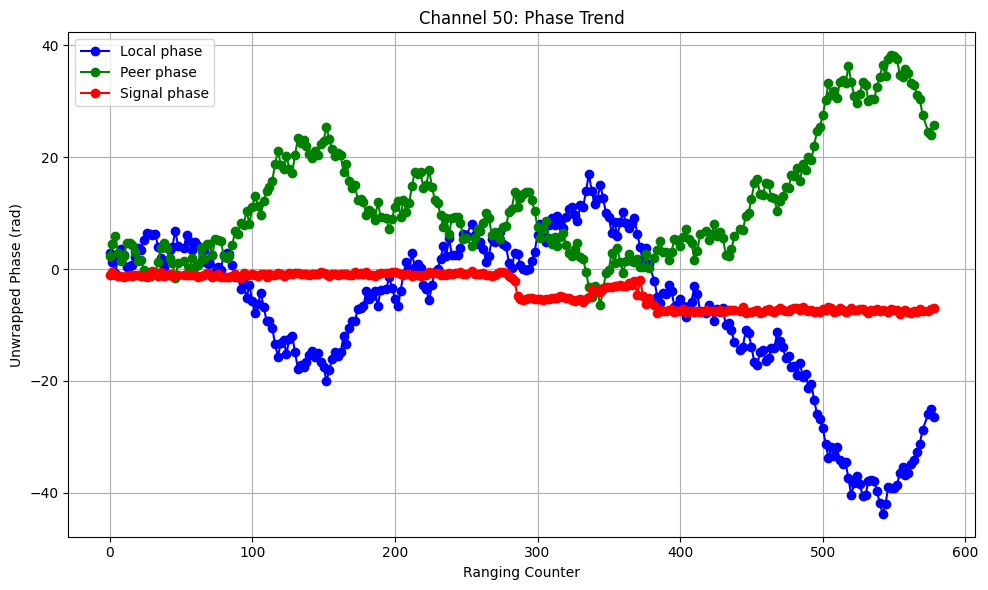

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_iq_trend(data_per_counter, channels_to_plot):
    """
    随着counter变化，绘制每个指定channel的local/peer/signal的幅值和相位趋势
    """
    counters = sorted(data_per_counter.keys())
    for ch in channels_to_plot:
        # 针对每个信道，收集各counter下的local/peer/signal幅值和相位
        local_amp, peer_amp, signal_amp = [], [], []
        local_phs, peer_phs, signal_phs = [], [], []
        valid_counters = []
        for counter in counters:
            ch_list = data_per_counter[counter]
            entry = next((e for e in ch_list if e['channel'] == ch), None)
            if entry is not None:
                local_amp.append(entry['local']['amplitude'])
                peer_amp.append(entry['peer']['amplitude'])
                signal_amp.append(entry['signal']['amplitude'])
                local_phs.append(entry['local']['phase'])
                peer_phs.append(entry['peer']['phase'])
                signal_phs.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if not valid_counters:
            print(f"Channel {ch} not found in any counter.")
            continue
        
        # 相位展开
        local_phs = np.unwrap(local_phs)
        peer_phs = np.unwrap(peer_phs)
        signal_phs = np.unwrap(signal_phs)
        
        # 画幅值
        plt.figure(figsize=(10,6))
        plt.plot(valid_counters, local_amp, 'b-o', label='Local amplitude')
        plt.plot(valid_counters, peer_amp, 'g-o', label='Peer amplitude')
        # plt.plot(valid_counters, signal_amp, 'r-o', label='Signal amplitude')
        plt.xlabel('Ranging Counter')
        plt.ylabel('Amplitude')
        plt.title(f'Channel {ch}: Amplitude Trend')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        # 画相位
        plt.figure(figsize=(10,6))
        plt.plot(valid_counters, local_phs, 'b-o', label='Local phase')
        plt.plot(valid_counters, peer_phs, 'g-o', label='Peer phase')
        plt.plot(valid_counters, signal_phs, 'r-o', label='Signal phase')
        # plt.ylim(-10, 10)
        plt.xlabel('Ranging Counter')
        plt.ylabel('Unwrapped Phase (rad)')
        plt.title(f'Channel {ch}: Phase Trend')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

# 用法举例
if __name__ == '__main__':
    # 假设 data_per_counter 已经由上面的 parse_and_process_iq 生成
    channels_to_plot = [2, 14, 29, 50]  # 你希望观察的信道号
    plot_iq_trend(data_per_counter, channels_to_plot)

local,peer,signal 的幅值相位变化。注意signal 的幅值就是peer，乘积的幅值没有实际意义。

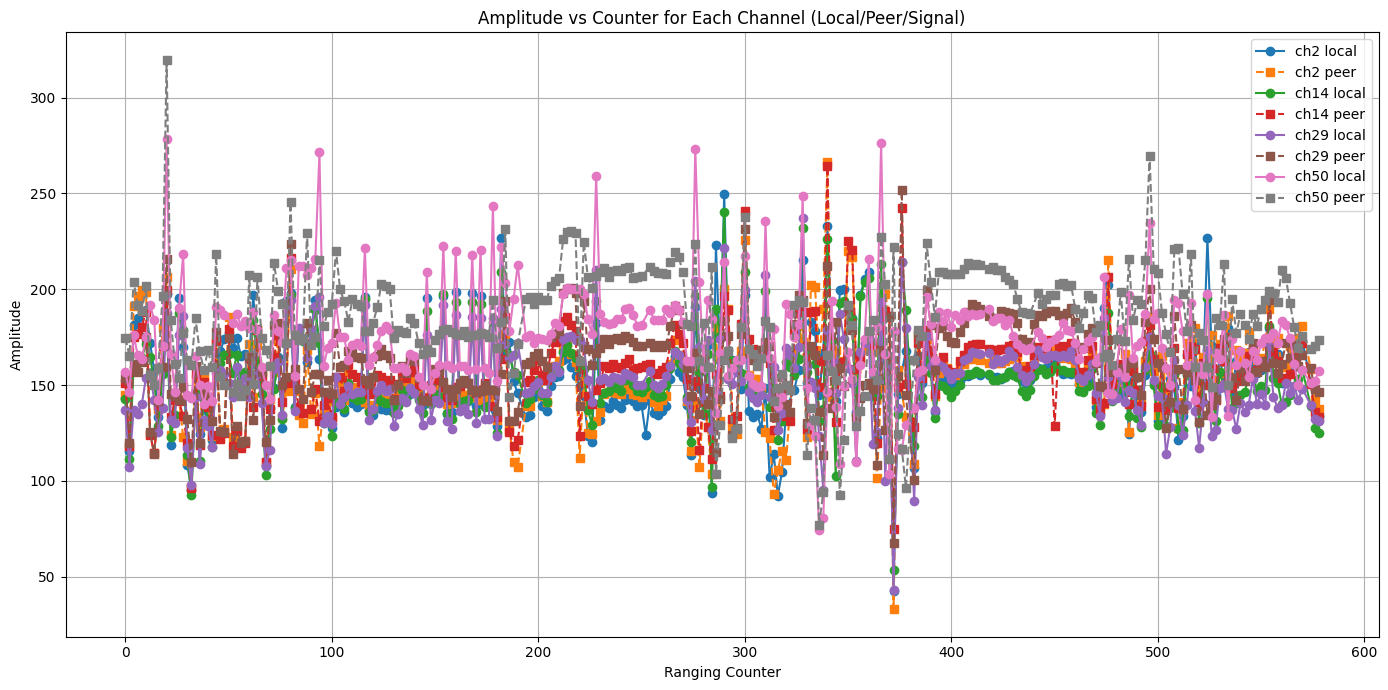

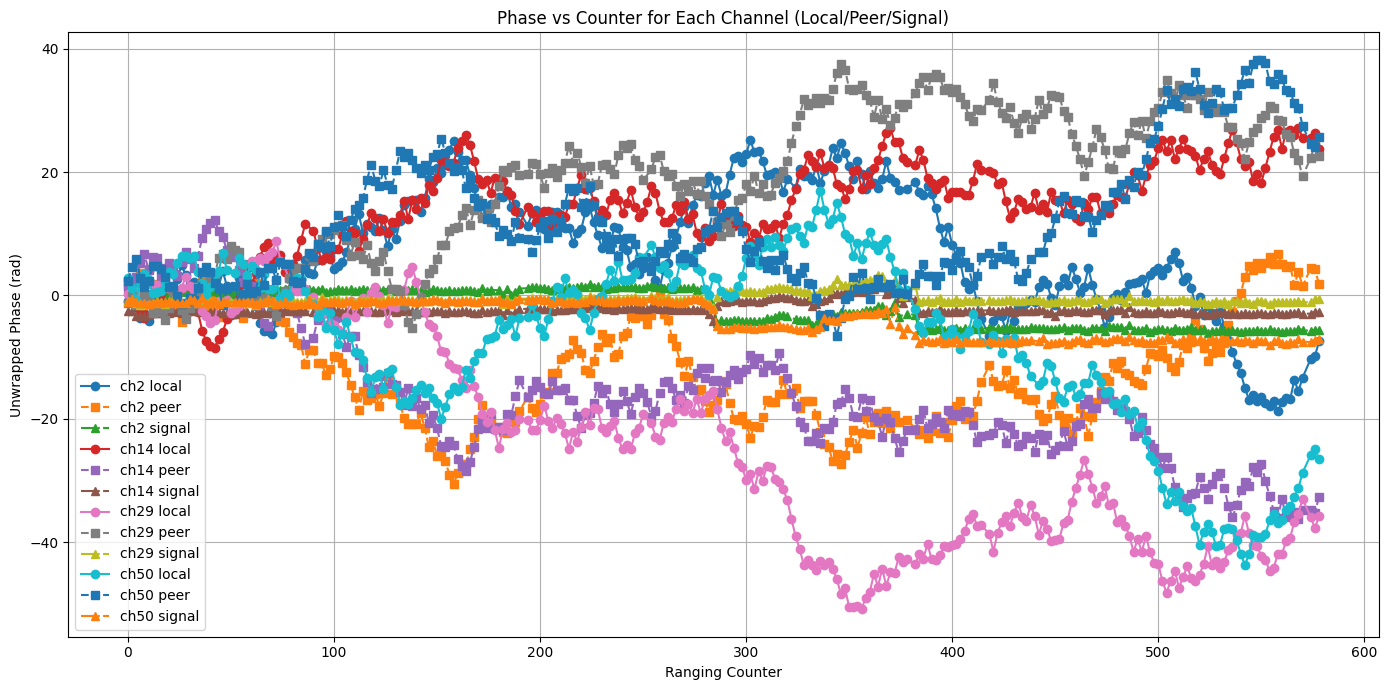

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_amplitude_vs_counter(data_per_counter, channels_to_plot):
    """
    幅值随counter变化。每个信道画三条曲线：local/peer/signal的amplitude。
    """
    counters = sorted(data_per_counter.keys())
    plt.figure(figsize=(14, 7))
    for ch in channels_to_plot:
        # 收集数据
        local_amp, peer_amp, signal_amp, valid_counters = [], [], [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                local_amp.append(entry['local']['amplitude'])
                peer_amp.append(entry['peer']['amplitude'])
                signal_amp.append(entry['signal']['amplitude'])
                valid_counters.append(counter)
        if valid_counters:
            plt.plot(valid_counters, local_amp, '-o', label=f'ch{ch} local')
            plt.plot(valid_counters, peer_amp, '--s', label=f'ch{ch} peer')
            # plt.plot(valid_counters, signal_amp, '-.^', label=f'ch{ch} signal')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Counter for Each Channel (Local/Peer/Signal)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_phase_vs_counter(data_per_counter, channels_to_plot):
    """
    相位随counter变化。每个信道画三条曲线：local/peer/signal的phase。
    """
    counters = sorted(data_per_counter.keys())
    plt.figure(figsize=(14, 7))
    for ch in channels_to_plot:
        local_phs, peer_phs, signal_phs, valid_counters = [], [], [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                local_phs.append(entry['local']['phase'])
                peer_phs.append(entry['peer']['phase'])
                signal_phs.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if valid_counters:
            # 相位展开
            local_phs = np.unwrap(local_phs)
            peer_phs = np.unwrap(peer_phs)
            signal_phs = np.unwrap(signal_phs)
            plt.plot(valid_counters, local_phs, '-o', label=f'ch{ch} local')
            plt.plot(valid_counters, peer_phs, '--s', label=f'ch{ch} peer')
            plt.plot(valid_counters, signal_phs, '-.^', label=f'ch{ch} signal')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Unwrapped Phase (rad)')
    plt.title('Phase vs Counter for Each Channel (Local/Peer/Signal)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 用法举例
if __name__ == '__main__':
    # 假设 data_per_counter 已由 parse_and_process_iq 生成
    channels_to_plot = [2, 14, 29, 50]  # 可自由指定
    plot_amplitude_vs_counter(data_per_counter, channels_to_plot)
    plot_phase_vs_counter(data_per_counter, channels_to_plot)

local,peer,signal 的幅值相位变化。注意signal 的幅值就是peer，乘积的幅值没有实际意义。

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_53684\3715841649.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


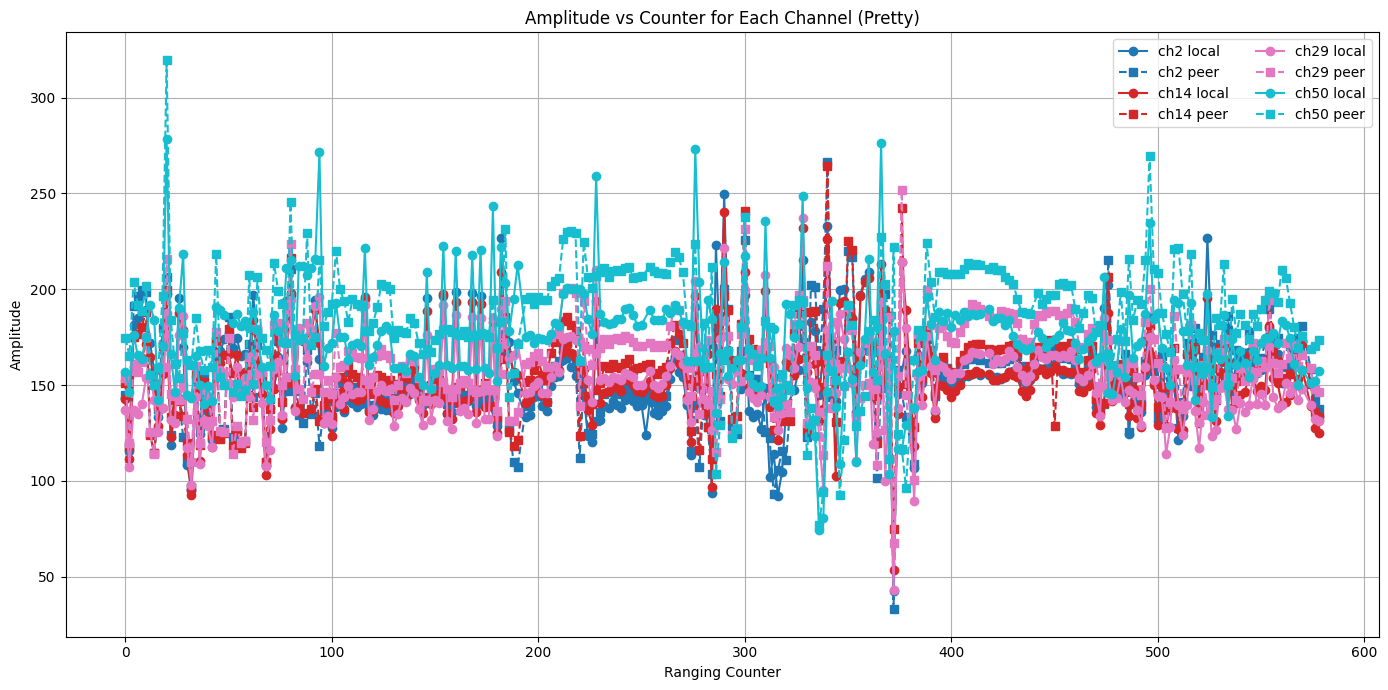

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_53684\3715841649.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


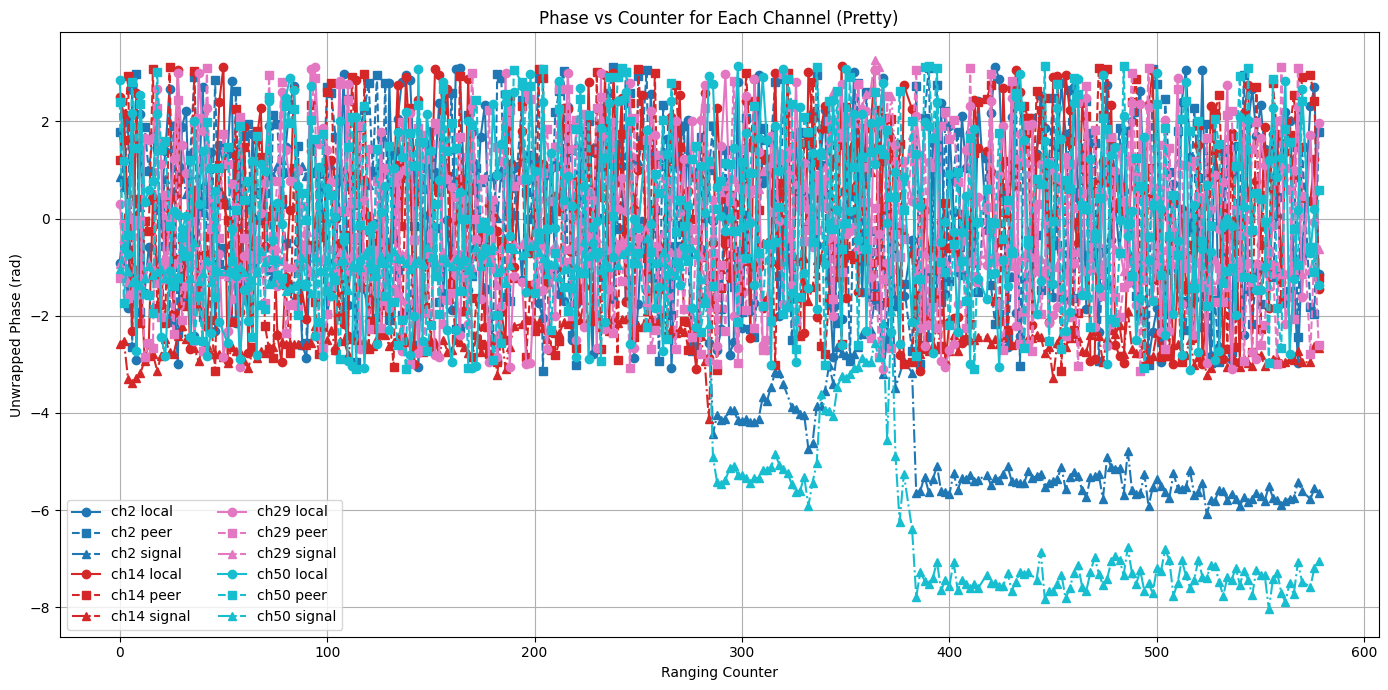

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_amplitude_vs_counter_pretty(data_per_counter, channels_to_plot):
    """
    更美观的幅值随counter变化图，同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    plt.figure(figsize=(14, 7))
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['amplitude'])
                    valid_counters.append(counter)
            if valid_counters:
                plt.plot(valid_counters, y, line_styles[kind], color=color,
                         label=f'ch{ch} {labels[kind]}')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Counter for Each Channel (Pretty)')
    plt.legend(loc='best', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_phase_vs_counter_pretty(data_per_counter, channels_to_plot):
    """
    更美观的相位随counter变化图，同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    plt.figure(figsize=(14, 7))
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer', 'signal']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['phase'])
                    valid_counters.append(counter)
            if valid_counters:
                if kind == 'signal':
                    # 对信号相位进行展开处理
                    y = np.unwrap(y)
                plt.plot(valid_counters, y, line_styles[kind], color=color,
                         label=f'ch{ch} {labels[kind]}')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Unwrapped Phase (rad)')
    plt.title('Phase vs Counter for Each Channel (Pretty)')
    plt.legend(loc='best', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

channels_to_plot = [2, 14, 29, 50]  # 可自由调节
plot_amplitude_vs_counter_pretty(data_per_counter, channels_to_plot)
plot_phase_vs_counter_pretty(data_per_counter, channels_to_plot)

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_53684\660477840.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


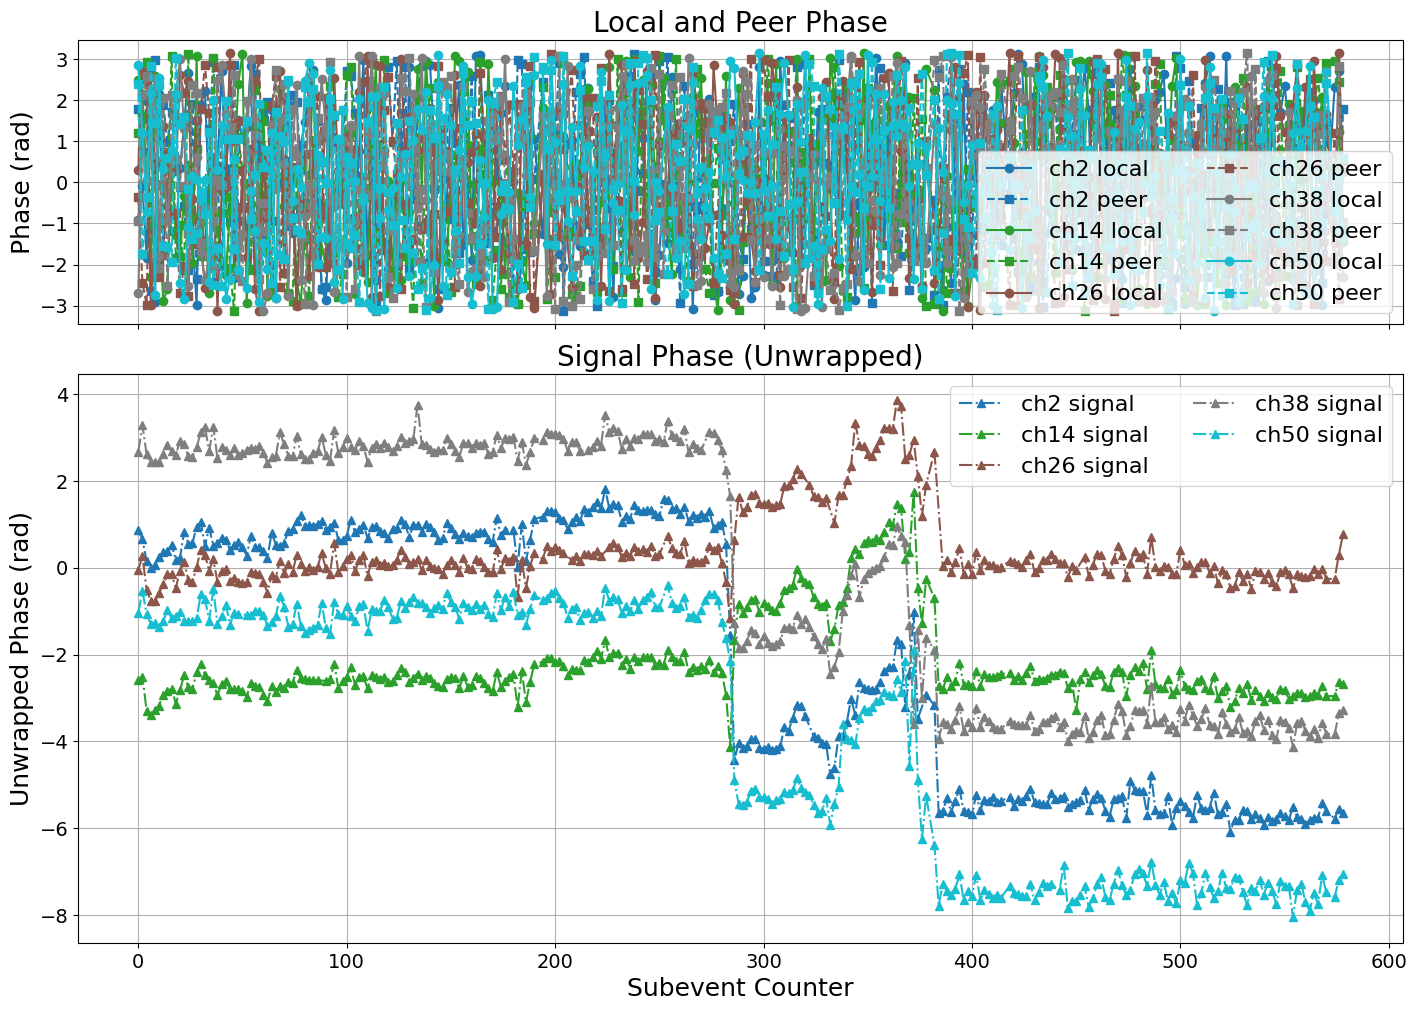

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_phase_vs_counter_pretty_subplots(data_per_counter, channels_to_plot):
    """
    local/peer 不展开，画在上面子图；
    signal 展开，画在下面子图；
    同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    markers = {'local': 'o', 'peer': 's', 'signal': '^'}
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    # cm=1/2.54  # cm to inch
    pt = 1/72.27  # point to inch
    linewidth = 246*pt
    textwidth = 506*pt  # 0.5 cm in points
    axis_label_size = 18   # 坐标轴标签字体
    title_size = 20        # 图标题字体
    legend_size = 16       # 图例字体
    tick_size = 14         # 坐标轴刻度字体
    scale_size = 3 #缩放倍数
    spine_width = 2 # 边框宽度

    fig, axs = plt.subplots(2, 1, figsize=(scale_size*1.4*linewidth, scale_size* 1.0 *linewidth), sharex=True, gridspec_kw={'height_ratios': [1, 2]})

    # 上面：local 和 peer
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['phase'])
                    valid_counters.append(counter)
            if valid_counters:
                axs[0].plot(valid_counters, y, line_styles[kind], color=color, label=f'ch{ch} {labels[kind]}')
                # axs[0].scatter(valid_counters, y, marker=markers[kind], color=color, s=10, label=f'ch{ch} {labels[kind]}', alpha=0.7)
    axs[0].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[0].set_title('Local and Peer Phase', fontsize=title_size)
    axs[0].legend(loc='best', ncol=2, fontsize=legend_size)
    axs[0].grid()
    
    # 下面：signal
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        y, valid_counters = [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                y.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if valid_counters:
            y = np.unwrap(y)
            axs[1].plot(valid_counters, y, line_styles['signal'], color=color, label=f'ch{ch} signal')
    axs[1].set_xlabel('Subevent Counter',fontsize=axis_label_size)
    axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[1].set_ylabel('Unwrapped Phase (rad)', fontsize=axis_label_size)
    axs[1].set_title('Signal Phase (Unwrapped)', fontsize=title_size)
    axs[1].legend(loc='best', ncol=2, fontsize=legend_size)
    axs[1].grid()

    plt.tight_layout()
    plt.savefig("./poster.fig/channel_variation_darkroom.svg", dpi=300)  # 保存图像
    plt.show()

# 用法
channels_to_plot = [2,  14,  26, 38, 50]
plot_phase_vs_counter_pretty_subplots(data_per_counter, channels_to_plot)



单次采样的相位变化，可见mode-0确实需要每一次都执行。否则，local应该是静止的

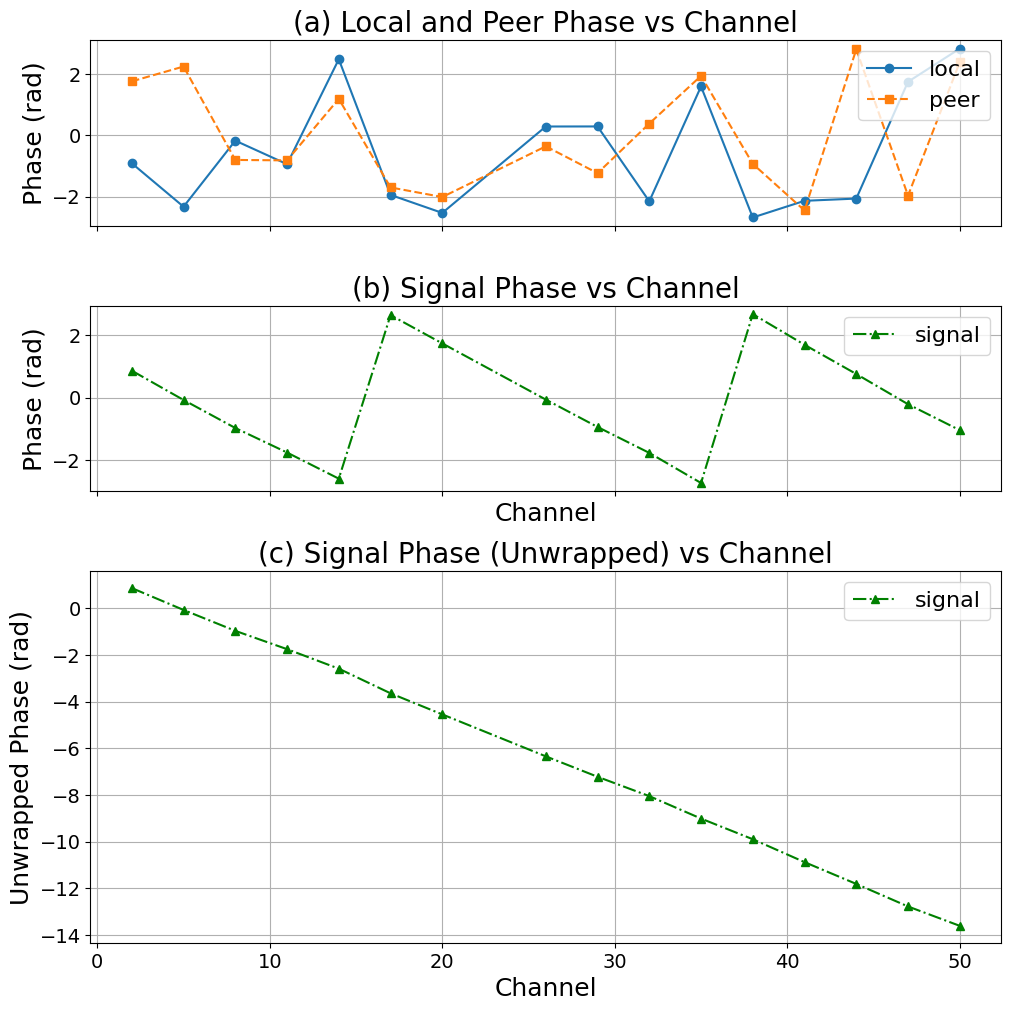

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_phase_vs_channel_at_counter(data_per_counter, counter):
    """
    展示某一counter下，所有channel的local/peer/signal相位随channel变化
    """
    if counter not in data_per_counter:
        print(f"Counter {counter} not found.")
        return
    ch_entries = sorted(data_per_counter[counter], key=lambda e: e['channel'])
    channels = [e['channel'] for e in ch_entries]
    # local_phs = np.unwrap([e['local']['phase'] for e in ch_entries])
    local_phs = [e['local']['phase'] for e in ch_entries]
    # peer_phs  = np.unwrap([e['peer']['phase']  for e in ch_entries])
    peer_phs  = [e['peer']['phase']  for e in ch_entries]
    signal_phs= [e['signal']['phase'] for e in ch_entries]
    signal_phs_uw= np.unwrap([e['signal']['phase'] for e in ch_entries])

    cm=1/2.54  # cm to inch
    pt = 1/72.27  # point to inch
    linewidth = 246*pt
    textwidth = 506*pt  # 0.5 cm in points
    axis_label_size = 18   # 坐标轴标签字体
    title_size = 20        # 图标题字体
    legend_size = 16       # 图例字体
    tick_size = 14         # 坐标轴刻度字体
    scale_size = 3 #缩放倍数
    spine_width = 2 # 边框宽度
    fig, axs = plt.subplots(3, 1, figsize=(scale_size*linewidth, scale_size* 1 *linewidth), sharex=True, gridspec_kw={'height_ratios': [1, 1,2]})

        # 上面：local 和 peer
    axs[0].plot(channels, local_phs, '-o', label='local')
    axs[0].plot(channels, peer_phs, '--s', label='peer')
    axs[0].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[0].set_title('(a) Local and Peer Phase vs Channel',fontsize=title_size)
    axs[0].legend(fontsize=legend_size, loc='upper right')
    axs[0].grid()
    axs[0].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体
    
    # 下面：signal
    axs[1].plot(channels, signal_phs, '-.^', label='signal', color='g')
    axs[1].set_xlabel('Channel',fontsize=axis_label_size)
    axs[1].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[1].set_title('(b) Signal Phase vs Channel',fontsize=title_size)
    axs[1].legend(fontsize=legend_size)
    axs[1].grid()
    axs[1].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体

    # 下面：signal unwrapped
    axs[2].plot(channels, signal_phs_uw, '-.^', label='signal', color='g')
    axs[2].set_xlabel('Channel',fontsize=axis_label_size)
    axs[2].set_ylabel('Unwrapped Phase (rad)',fontsize=axis_label_size)
    axs[2].set_title('(c) Signal Phase (Unwrapped) vs Channel',fontsize=title_size)
    axs[2].legend(fontsize=legend_size)
    axs[2].grid()
    axs[2].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体

    plt.tight_layout()
    plt.savefig(f'./poster.fig/counter_{counter}_phase_vs_channel.svg', dpi=300)
    plt.savefig(f'./poster.fig/counter_{counter}_phase_vs_channel.pdf', dpi=300)
    plt.show()

plot_phase_vs_channel_at_counter(data_per_counter, counter=0)  # counter编号可自定